# Omnigot One-Shot with Virtual Branching

In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import copy
import cv2
from scipy.spatial import distance

In [2]:
import vbranch as vb
from vbranch.applications.resnet import ResNet18
from vbranch.applications.cnn import SimpleCNNLarge
from vbranch.utils.training_utils import wrap_iterator
from vbranch.utils.test_utils import baseline_one_shot, vbranch_one_shot, restore_sess
from vbranch.utils import TFSessionGrow
from vbranch.losses import triplet

In [3]:
MODEL_ID = 1
ARCHITECTURE = 'res'
DATASET = 'omniglot'
NUM_BRANCHES = 1
SHARED_FRAC = None

EPOCHS = 50
STEPS_PER_EPOCH = 100
T_0 = 30
OUTPUT_DIM = 128

## Load Data

In [4]:
if DATASET == 'omniglot':
    A, P, K = 4, 8, 4
    train_generator = vb.datasets.omniglot.load_generator('train')
    test_generator = vb.datasets.omniglot.load_generator('test')
elif DATASET == 'market':
    P, K = 18, 4
    train_generator = vb.datasets.reid.TripletDataGenerator(dataset, 'train')

In [5]:
batch = train_generator.next(4, 4, 4, flatten=False, preprocess=False)

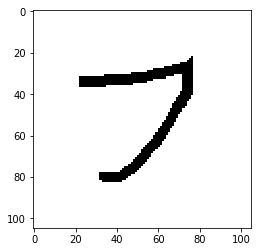

In [6]:
plt.imshow(batch[0, 3, 0].squeeze(), cmap=plt.cm.gray)
plt.show()

## Build Model

In [7]:
if not os.path.isdir('models'):
    os.system('mkdir models')

if NUM_BRANCHES == 1:
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
else:
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(DATASET, ARCHITECTURE,
                                        NUM_BRANCHES, SHARED_FRAC, MODEL_ID)
model_path = os.path.join('models', model_name)
print(model_path)

models/omniglot-res_1


In [8]:
input_dim = (None,) + batch.shape[-3:]
print(input_dim)

tf.reset_default_graph()

# Placeholder for feeding test images
x = tf.placeholder('float32', input_dim, name='x')
batch_size = tf.placeholder('int64', name='batch_size')

inputs = []
train_init_op = []
test_init_op = []

for i in range(NUM_BRANCHES):
    train_dataset = tf.data.Dataset.from_generator(wrap_iterator(train_generator, A, P, K),
                                                   'float32', output_shapes=input_dim)
    test_dataset = tf.data.Dataset.from_tensor_slices(x).batch(batch_size)
    iterator = tf.data.Iterator.from_structure('float32', input_dim)
    
    if NUM_BRANCHES == 1:
        inputs = iterator.get_next()
        train_init_op = iterator.make_initializer(train_dataset)
        test_init_op = iterator.make_initializer(test_dataset, name='test_init_op')
    else:
        inputs.append(iterator.get_next(name='input_'+str(i+1)))
        train_init_op.append(iterator.make_initializer(train_dataset))
        test_init_op.append(iterator.make_initializer(test_dataset, 
                                                      name='test_init_op_'+str(i+1)))

(None, 105, 105, 1)
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
Instructions for updating:
Colocations handled automatically by placer.


In [9]:
name = 'model_' + str(MODEL_ID)

with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
    if ARCHITECTURE == 'simple':
        model = SimpleCNNLarge(inputs, OUTPUT_DIM, name=name, shared_frac=SHARED_FRAC)
    elif ARCHITECTURE == 'res':
        model = ResNet18(inputs, OUTPUT_DIM, name=name, shared_frac=SHARED_FRAC)

model.summary()

i   Layer name                      Output shape      Parameters           Num param  Inbound             
----------------------------------------------------------------------------------------------------------
    Input                           [None,105,105,1]                                                      
----------------------------------------------------------------------------------------------------------
0   pre_conv (Conv2D)               [None,53,53,64]   [7,7,1,64] [64]      3200       IteratorGetNext:0   
----------------------------------------------------------------------------------------------------------
1   pre_bn (BatchNormalization)     [None,53,53,64]   [64] [64]            128        pre_conv            
----------------------------------------------------------------------------------------------------------
2   pre_relu (Activation)           [None,53,53,64]                        0          pre_bn              
-------------------------------------

In [10]:
print(model.output)

Tensor("model_1/output/output:0", shape=(?, 128), dtype=float32)


In [11]:
def lr_exp_decay_scheduler(init_lr, t0, t1, decay):
    """NOTE: `episode` starts from 1"""
    def func(episode):
        if episode < t0:
            return init_lr
        lr = init_lr * np.power(decay, (episode - t0) / (t1 - t0))
        return lr
    return func

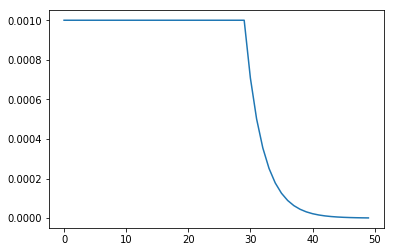

In [12]:
lr_scheduler = lr_exp_decay_scheduler(0.001, T_0, EPOCHS, 0.001)
lr_steps = [lr_scheduler(e + 1) for e in range(EPOCHS)]
plt.plot(lr_steps)
plt.show()

In [13]:
lr = tf.placeholder('float32', name='lr')
optimizer = tf.train.AdamOptimizer(learning_rate=lr)

# Compile model
model.compile(optimizer, 'triplet_omniglot', A=A, P=P, K=K)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [14]:
with TFSessionGrow() as sess:
    sess.run(tf.global_variables_initializer())
    
    if NUM_BRANCHES == 1:
        loss = model.loss
        train_op = model.train_op
    else:
        loss = model.losses
        train_op = model.train_ops

    for e in range(EPOCHS):
        print("Epoch {}/{}".format(e + 1, EPOCHS))
        progbar = tf.keras.utils.Progbar(STEPS_PER_EPOCH)
        sess.run(train_init_op)
        learning_rate = lr_scheduler(e + 1)
        
        for i in range(STEPS_PER_EPOCH):
            _, loss_values = sess.run([train_op, loss], 
                                      feed_dict={lr:learning_rate})
            
            # Update progress bar
            if NUM_BRANCHES == 1:
                values = [('loss', loss_values), ('lr', learning_rate)]
                if i == STEPS_PER_EPOCH - 1:
                    values.append(('acc', baseline_one_shot(sess, model_name=name)))
            else:
                values = []
                
                if i == STEPS_PER_EPOCH - 1:
                    acc, baseline_acc_list = vbranch_one_shot(sess, model_name=name, 
                                                              n_branches=NUM_BRANCHES)
                    values.append(('acc_ensemble', acc))
                    
                for b in range(NUM_BRANCHES):
                    key = 'loss_'+str(b+1)
                    values.append((key, loss_values[key]))
                    if i == STEPS_PER_EPOCH - 1:
                        values.append(('acc_'+str(b+1), baseline_acc_list[b]))
                        
                values.append(('lr', learning_rate))
            
            progbar.update(i + 1, values=values)
    
    saver = tf.train.Saver()
    path = os.path.join(model_path, 'ckpt')
    saver.save(sess, path)

Epoch 1/50
100/100 [==============================] - 32s 315ms/step - loss: 183.0801 - lr: 0.0010 - acc: 0.3850
Epoch 2/50
100/100 [==============================] - 15s 154ms/step - loss: 43.6197 - lr: 0.0010 - acc: 0.3925
Epoch 3/50
100/100 [==============================] - 15s 154ms/step - loss: 47.4357 - lr: 0.0010 - acc: 0.4050
Epoch 4/50
100/100 [==============================] - 15s 154ms/step - loss: 34.5992 - lr: 0.0010 - acc: 0.4925
Epoch 5/50
100/100 [==============================] - 16s 157ms/step - loss: 30.5089 - lr: 0.0010 - acc: 0.5825
Epoch 6/50
100/100 [==============================] - 15s 154ms/step - loss: 31.5411 - lr: 0.0010 - acc: 0.5850
Epoch 7/50
100/100 [==============================] - 15s 154ms/step - loss: 32.8864 - lr: 0.0010 - acc: 0.5300
Epoch 8/50
100/100 [==============================] - 15s 154ms/step - loss: 27.7138 - lr: 0.0010 - acc: 0.6125
Epoch 9/50
100/100 [==============================] - 15s 154ms/step - loss: 24.2260 - lr: 0.0010 - acc

## Evaluation

### Baseline

In [15]:
assert NUM_BRANCHES == 1

model_id_list = [1]
baseline_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    model_name = '{}-{}_{:d}'.format(DATASET, ARCHITECTURE, MODEL_ID)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)
        acc = baseline_one_shot(sess, model_name='model_'+str(model_id))
        print('Model {} acc:'.format(model_id), acc)
        baseline_acc_list.append(acc)
        
print('Mean acc:', np.mean(baseline_acc_list), ', std:', np.std(baseline_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/omniglot-res_1/ckpt
Model 1 acc: 0.8049999999999999
Mean acc: 0.8049999999999999 , std: 0.0


### Virtual Branching

In [8]:
model_id_list = [1]
vbranch_acc_list = []

for model_id in model_id_list:
    tf.reset_default_graph()
    
    model_name = 'vb-{}-{}-B{:d}-S{:.2f}_{:d}'.format(dataset, architecture,
                                            NUM_BRANCHES, SHARED_FRAC, model_id)
    model_path = os.path.join('models', model_name)
    
    with TFSessionGrow() as sess:
        restore_sess(sess, model_path)    
        acc, branch_acc = vbranch_one_shot(sess, model_name='model_'+str(model_id), 
                                           n_branches=NUM_BRANCHES)
        print('Model {} acc:'.format(model_id), acc, branch_acc)
        vbranch_acc_list.append(acc)
        
print('Mean acc:', np.mean(vbranch_acc_list), ', std:', np.std(vbranch_acc_list))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/vb-omniglot-res-B2-S0.25_1/ckpt
Model 1 acc: 0.8375 [0.7849999999999999, 0.8125]
Mean acc: 0.8375 , std: 0.0
